### CFD Tutorial
YouTube: [Solving the Navier-Stokes equations in Python | CFD in Python | Lid-Driven Cavity](https://youtu.be/BQLvNLgMTQE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
N_POINTS = 41
DOMAIN_SIZE = 1
N_ITERATIONS = 500
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0
VERTICAL_VELOCITY_TOP = 1
N_PRESSURE_POISSON_ITERATIONS = 50

In [4]:
element_length = DOMAIN_SIZE / (N_POINTS - 1)

x = np.linspace(0, DOMAIN_SIZE*34/25, N_POINTS)
y = np.linspace(0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

u_prev = np.full_like(X, 0)
v_prev = np.full_like(X, 0)
p_prev = np.full_like(X, 0)

In [5]:
def central_diff_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 2:]
        -
        f[1:-1, 0:-2]
    ) / (
        2 * element_length
    )

    return diff

def central_diff_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:, 1:-1]
        -
        f[0:-2, 1:-1]
    ) / (
        2 * element_length
    )

    return diff

def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2]
        +
        f[0:-2, 1:-1]
        -
        4
        *
        f[1:-1, 1:-1]
        +
        f[1:-1, 2:]
        +
        f[2:, 1:-1]
    ) / (
        element_length**2
    )

    return diff

In [6]:
for _ in tqdm(range(N_ITERATIONS)):
    d_u_prev__d_x = central_diff_x(u_prev)
    d_u_prev__d_y = central_diff_x(u_prev)

    d_v_prev__d_x = central_diff_x(u_prev)
    d_v_prev__d_y = central_diff_x(u_prev)

    laplace__u_prev = laplace(u_prev)
    laplace__v_prev = laplace(v_prev)

    # Perform a tentative step by solving the momentum eq. without the pressure gradient.
    u_tent = (
        u_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_u_prev__d_x
                +
                v_prev * d_u_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__u_prev
        )
    )

    v_tent = (
        v_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_v_prev__d_x
                +
                v_prev * d_v_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__v_prev
        )
    )

    # Velocity Boundary Conditions: Homogenous Dirichlet BC everywhere except for the horizontal velocity at the top,
    # which is prescribed.
    u_tent[0, :] = 0
    u_tent[:, 0] = 0
    u_tent[:, -1] = 0
    u_tent[-1, :] = u_tent[:, -2]

    v_tent[0, :] = 0
    v_tent[:, 0] = VERTICAL_VELOCITY_TOP
    v_tent[:, -1] = 0
    v_tent[-1, :] = 0

    d_u_tent__d_x = central_diff_x(u_tent)
    d_v_tent__d_y = central_diff_y(v_tent)

    # Compute a pressure correction by solving the pressure-poisson eq.
    rhs = (
        DENSITY / TIME_STEP_LENGTH
        *
        (
            d_u_tent__d_x
            +
            d_v_tent__d_y
        )
    )

    for _ in range(N_PRESSURE_POISSON_ITERATIONS):
        p_next = np.zeros_like(p_prev)

        p_next[1:-1, 1:-1] = 1/4 * (
            p_prev[1:-1, 0:-2]
            +
            p_prev[0:-2, 1:-1]
            +
            p_prev[1:-1, 2:]
            +
            p_prev[2:, 1:-1]
            -
            element_length**2
            *
            rhs[1:-1, 1:-1]
        )

        # Pressure Boundary Conditions: Homogeneous Neumann Boundary Conditions everywhere except for the top,
        # where it is a homogeneous Dirichlet BC
        p_next[:, -1] = p_next[:, -2]
        p_next[0, :] = p_next[1, :]
        p_next[:, 0] = p_next[:, 1]
        p_next[-1, :] = 0.0

        p_prev = p_next

    d_p_next__d_x = central_diff_x(p_next)
    d_p_next__d_y = central_diff_y(p_next)

    # Correct the velocities such that the fluid stays incompressible
    u_next = (
        u_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_x
    )

    v_next = (
        v_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_y
    )

    # Velocity Boundary Conditions: Homogenous Dirichlet BC everywhere except for the horizontal velocity at the top,
    # which is prescribed.
    u_next[0, :] = 0
    u_next[:, 0] = 0
    u_next[:, -1] = 0
    u_next[-1, :] = u_next[-2, :]

    v_next[0, :] = 0
    v_next[:, 0] = VERTICAL_VELOCITY_TOP
    v_next[:, -1] = 0
    v_next[-1, :] = 0

    # Advance in time
    u_prev = u_next
    v_prev = v_next
    p_prev = p_next

100%|██████████| 500/500 [00:00<00:00, 1293.13it/s]


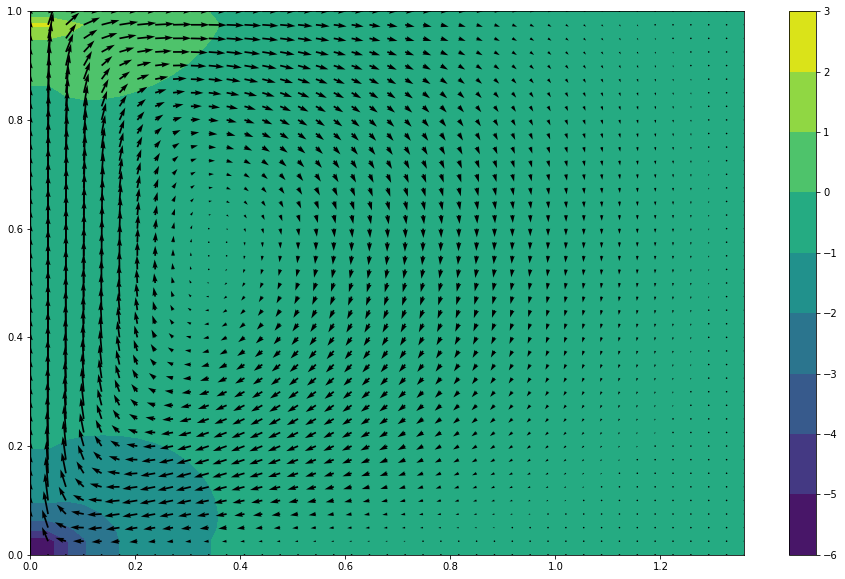

In [7]:
plt.figure(figsize=(16, 10))

plt.contourf(X, Y, p_next)
plt.colorbar()

plt.quiver(X, Y, u_next, v_next, color='k')
plt.show()

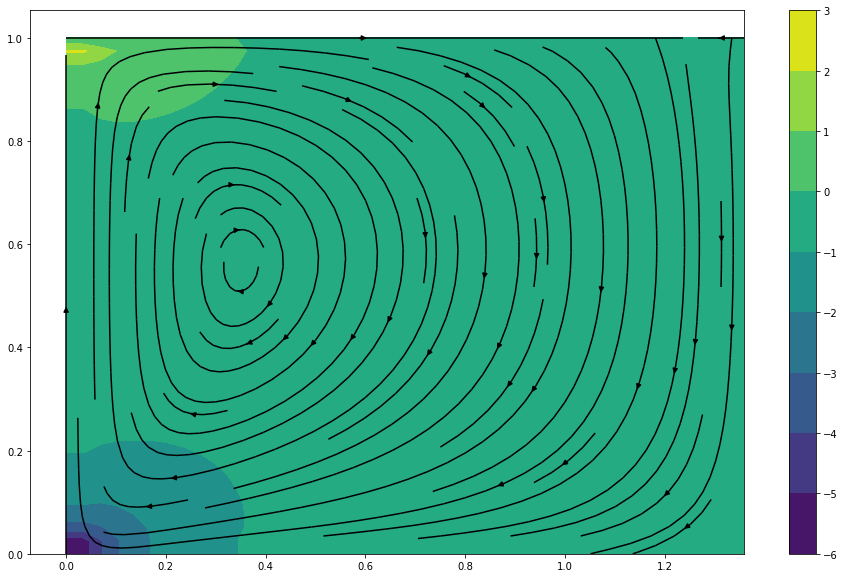

In [8]:
plt.figure(figsize=(16, 10))

plt.contourf(X, Y, p_next)
plt.colorbar()

plt.streamplot(X, Y, u_next, v_next, color='k')
plt.show()

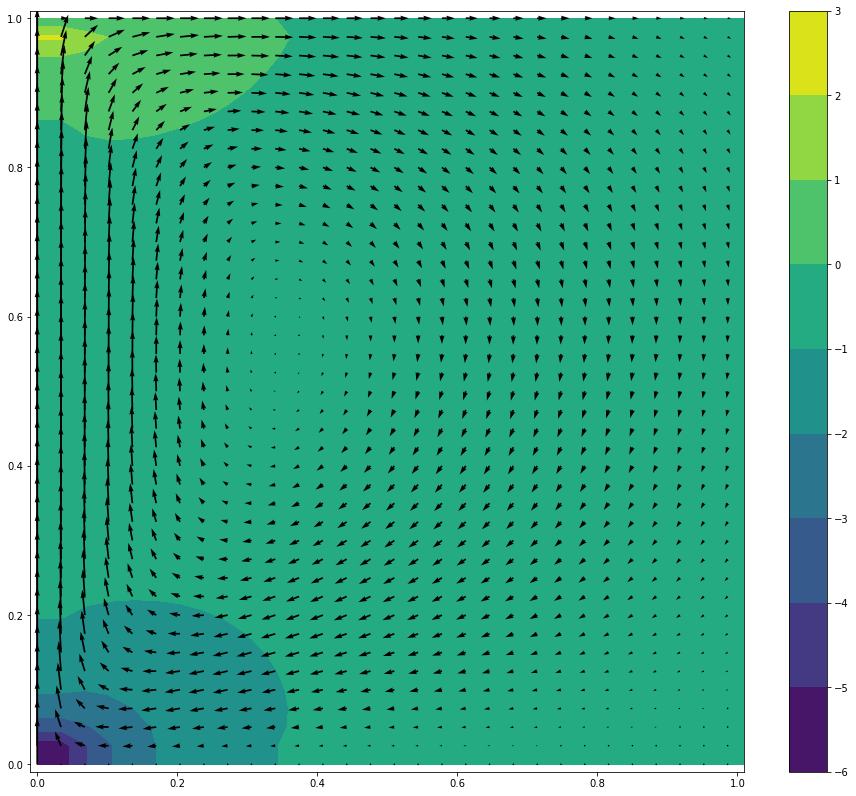

In [9]:
plt.figure(figsize=(16, 14))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)

plt.contourf(X, Y, p_next)
plt.colorbar()

plt.quiver(X, Y, u_next, v_next, color='k')
plt.show()

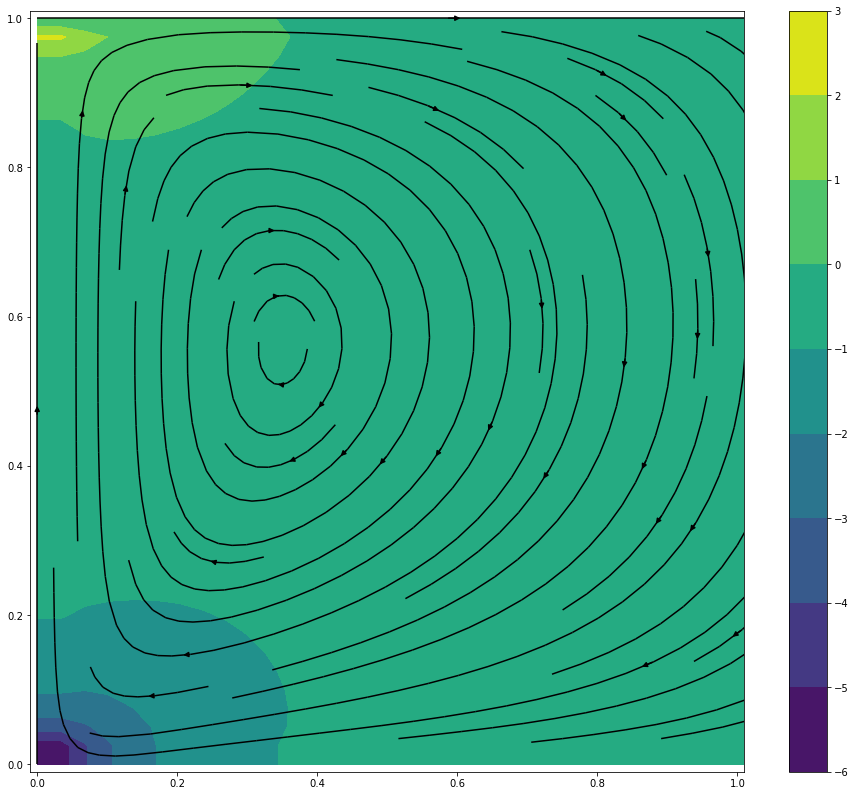

In [10]:
plt.figure(figsize=(16, 14))
plt.contourf(X, Y, p_next)
plt.colorbar()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# plt.quiver(X, Y, u_next, v_next, color='k')
plt.streamplot(X, Y, u_next, v_next, color='k')
plt.show()

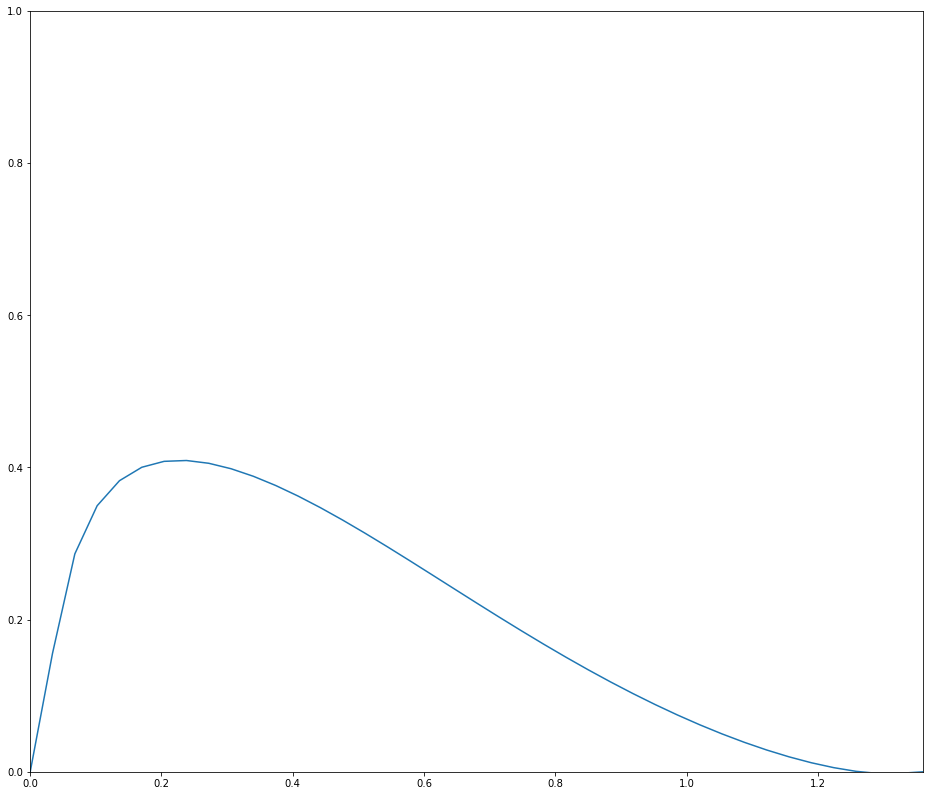

In [14]:
plt.figure(figsize=(16, 14))
plt.xlim(0, 1*34/25)
plt.ylim(0, 1)

plt.plot(x, u_next[-1, :])

plt.show()